In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp; from scipy.io import wavfile; from scipy import signal
import pydub
from pydub import AudioSegment

The sampling rate of the audio files.

In [2]:
sr = 44100

Little function used to write to audio files.

In [3]:
def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

# Get Data

In [4]:
df_a = pd.read_pickle("./acoustic_df.pkl")

In [5]:
E = np.array(df_a['E'].dropna()); Em = np.array(df_a['E_mute'].dropna()); 
A = np.array(df_a['A'].dropna()); Am = np.array(df_a['A_mute'].dropna()); 
D = np.array(df_a['D'].dropna()); Dm = np.array(df_a['D_mute'].dropna()); 
G = np.array(df_a['G'].dropna()); Gm = np.array(df_a['G_mute'].dropna()); 
B = np.array(df_a['B'].dropna()); Bm = np.array(df_a['B_mute'].dropna()); 
Eh = np.array(df_a['Eh'].dropna()); Ehm = np.array(df_a['Eh_mute'].dropna()); 

In [6]:
len(D)

175104

# Sampling Experiment

Below we reduce the sampling rate by a factor of 100. This changes the nyquist frequency, and now frequencies beyond the nyquist frequency become indistinguishable from lower frequencies (all higher frequencies get "folded in"- see Fig 98 spec analysis)

In [7]:
def new_rate(arr, scale):
    return arr[0::scale].astype(int)

Reduce the sampling rate and write to a new mp3 file.

In [8]:
E_new = new_rate(E, 100)
write('modified_sounds/ac_E_subsamp.mp3', sr/100, E_new, normalized=False)

Obtain the periodogram.

In [9]:
f_E, Pxx_den_E = signal.periodogram(E, sr)
f_E_new, Pxx_den_E_new = signal.periodogram(E_new, sr/100)

Manually "Flip the Frequencies" inward on the normal periodogram. This should be identical to the sub-sampled periodogram (see Figure 145 Spec Analysis)

In [10]:
def split_padded(a,n):
    padding = (-len(a))%n
    return np.split(np.concatenate((a,np.zeros(padding))),n)

def fold_in(prdg, scale):
    f = split_padded(prdg, scale)
    N = len(f[0])
    
    ff = np.linspace(0, 1/2, N) *sr/scale
    new_prdg = f[0]
    for (i, arr) in enumerate(f[1:]):
        if i%2 == 1:
            new_prdg += arr
        else:
            new_prdg += np.flip(arr)
    
    
    return ff, new_prdg

Plot

In [11]:
f_E_fold, Pxx_den_E_fold = fold_in(Pxx_den_E, 100)

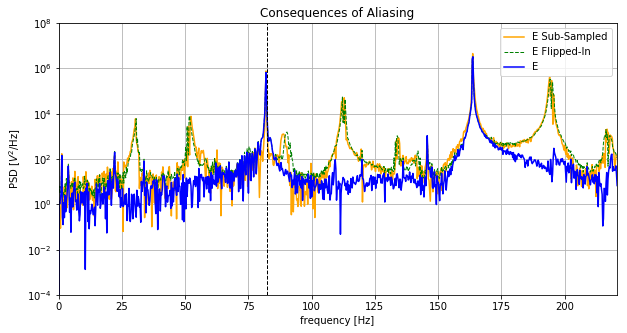

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(f_E_new, Pxx_den_E_new, label='E Sub-Sampled', c='orange')
ax.semilogy(f_E_fold, Pxx_den_E_fold, label='E Flipped-In', ls='--', lw=1, c='green')
ax.semilogy(f_E, Pxx_den_E, label='E', c='blue')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [$V^2$/Hz]')
ax.set_xlim(0,(sr/100)/2)
ax.set_ylim(10**-4, 10**8)
ax.legend()
ax.grid()
ax.set_title('Consequences of Aliasing')


# Main Frequencies of a Guitar in Tune
ax.axvline(82.4, ls='--', color='k', lw=1)

plt.savefig('test_plot.png', dpi=300)
plt.show()

Automatically create the plots for the other notes

In [23]:
def make_plot(note, notename, notefreq, red, legend=False):
    
    # Create the subsampled note and write to a new file
    note_sub = new_rate(note, red)
    write('modified_sounds/ac_'+notename+'_subsamp.mp3', sr/red, note_sub, normalized=False)
    
    #Get Periodograms
    ff, Pxx = signal.periodogram(note, sr)
    ff_sub, Pxx_sub = signal.periodogram(note_sub, sr/red)
    ff_fold, Pxx_fold= fold_in(Pxx, red)
    
    # Plot
    fig, ax = plt.subplots(1,1, figsize=(6,3))

    ax.semilogy(ff_sub, Pxx_sub, label='Sub-Sampled', c='orange')
    ax.semilogy(ff_fold, Pxx_fold, label='Flipped-In', ls='--', lw=1, c='green')
    ax.semilogy(ff, Pxx, label='Normal Sampling', c='blue')


    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('$\hat{S}^{(p)}(f)$ [$V^2$/Hz]')
    ax.set_xlim(0,(sr/red)/2)
    ax.set_ylim(10**-4, 10**8)
    
    if legend:
        ax.legend(loc='lower right')
    ax.grid()
    ax.set_title(notename+' String')


    # Main Frequencies of a Guitar in Tune
    ax.axvline(notefreq, ls='--', color='k', lw=1)
    
    fig.tight_layout()
    plt.savefig('plots/aliasing/'+notename+'_aliased.png', dpi=300)
    plt.close()

In [24]:
make_plot(E, 'E', 82.4, 100, legend=True)
make_plot(A, 'A', 110, 100)
make_plot(D, 'D', 146.83, 100)
make_plot(G, 'G', 196, 100)
make_plot(B, 'B', 246.94, 100)
make_plot(Eh, 'Eh', 329.63, 100)